In [2]:
from kaggle_datasets import KaggleDatasets
import numpy as np 
import pandas as pd

import os

max_output = 10
current_output = 0

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        if current_output < max_output:
            print(os.path.join(dirname, filename))
            current_output += 1
        else:
            break

/kaggle/input/gan-getting-started/monet_jpg/f4413e97bd.jpg
/kaggle/input/gan-getting-started/monet_jpg/7341d96c1d.jpg
/kaggle/input/gan-getting-started/monet_jpg/de6f71b00f.jpg
/kaggle/input/gan-getting-started/monet_jpg/99d94af5dd.jpg
/kaggle/input/gan-getting-started/monet_jpg/99a51d3e25.jpg
/kaggle/input/gan-getting-started/monet_jpg/d05cab011d.jpg
/kaggle/input/gan-getting-started/monet_jpg/4e05523825.jpg
/kaggle/input/gan-getting-started/monet_jpg/c68c52e8fc.jpg
/kaggle/input/gan-getting-started/monet_jpg/40d7d18ad3.jpg
/kaggle/input/gan-getting-started/monet_jpg/f96a8de9f3.jpg


In [3]:
import os

print(os.listdir('/kaggle/input/'))

monet_tfrec_path = '/kaggle/input/gan-getting-started/monet_tfrec/*.tfrec'
photo_tfrec_path = '/kaggle/input/gan-getting-started/photo_tfrec/*.tfrec'

['gan-getting-started']


# GANs Kaggle Mini-Project
*** 
This project is about creating a Generative Adversarial Network (GAN) that can translate input images into the style of Claude Monet's paintings. Going to be honest, I had no idea who that was, but this sounded like a good challenge, so I'm all for it. The most important thing is understanding the characteristics that make a Claude Monet painting what is is, such as brush strokes, color palettes, subjects, etc. I will then teach the model to apply these elements to new images. The description for the dataset describes there being a collection of Monet paintings, which will be the main focus for the GAN. Above, I had it output only the first ten pictures since it tried to do all of them which would cause four hours of scrolling. We also have a set of photographs that will act as the input domain that the model will use to learn how to turn the photos to the Monet style. It looks as though each image is 256x256 pixels and is stored in JPEG and TFRecord format. There are 300 Monet images and 7,028 photos available for training the CycleGAN.

When it comes to EDA, I will load some sample images from both the Monet paintings and the photgraphs to visualize the characteristics of each. I'll display the images in a grid for comparison so that the differences between the two styles are clear. I'll look at examining the subjects of the photographs and paintings as well as checking the distribution across both style of photos when it comes to color.

In [4]:
import tensorflow as tf
import logging

tf.get_logger().setLevel(logging.ERROR)

IMAGE_SIZE = [256, 256] 
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [5]:
GCS_PATH = KaggleDatasets().get_gcs_path('gan-getting-started')
MONET_FILENAMES = tf.io.gfile.glob(str(GCS_PATH + '/monet_tfrec/*.tfrec'))
PHOTO_FILENAMES = tf.io.gfile.glob(str(GCS_PATH + '/photo_tfrec/*.tfrec'))

Below we will output a photo from the Monet paintings and a normal photo. It's set to be a random photo from each style each time the code is ran.

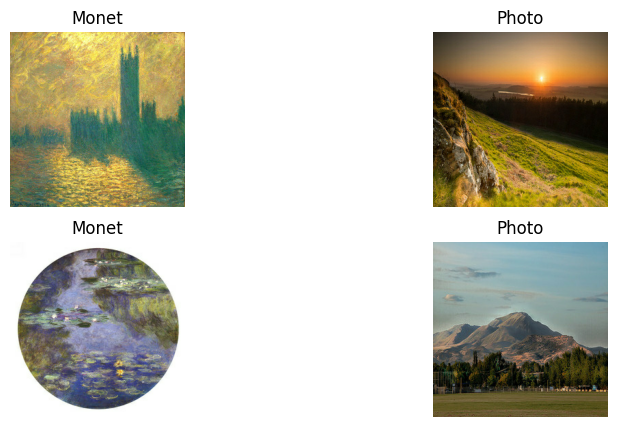

In [6]:
import matplotlib.pyplot as plt

def decode_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = (tf.cast(image, tf.float32) / 127.5) - 1
    image = tf.reshape(image, [*IMAGE_SIZE, 3])
    return image

def read_tfrecord(example):
    tfrecord_format = {
        "image_name": tf.io.FixedLenFeature([], tf.string),
        "image": tf.io.FixedLenFeature([], tf.string),
        "target": tf.io.FixedLenFeature([], tf.string)
    }
    example = tf.io.parse_single_example(example, tfrecord_format)
    image = decode_image(example['image'])
    return image

def load_dataset(filenames, labeled=True):
    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.map(read_tfrecord, num_parallel_calls=AUTOTUNE)
    return dataset

def visualize_dataset(monet_ds, photo_ds, num_samples=2):
    monet_images = next(iter(monet_ds))  # Get a batch of Monet images
    photo_images = next(iter(photo_ds))  # Get a batch of Photo images
    
    plt.figure(figsize=(10, 5))
    for i in range(num_samples):
        plt.subplot(num_samples, 2, i * 2 + 1)
        plt.title('Monet')
        plt.imshow(monet_images[i] * 0.5 + 0.5)
        plt.axis('off')

        plt.subplot(num_samples, 2, i * 2 + 2)
        plt.title('Photo')
        plt.imshow(photo_images[i] * 0.5 + 0.5)
        plt.axis('off')

    plt.show()

BATCH_SIZE = 4

monet_ds = (
    load_dataset(MONET_FILENAMES, labeled=True)
    .shuffle(buffer_size=1000)
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE)
)

photo_ds = (
    load_dataset(PHOTO_FILENAMES, labeled=True)
    .shuffle(buffer_size=1000)
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE)
)

visualize_dataset(monet_ds, photo_ds)

Pretty cool comparison. Next, I will just show five of each style so we can get more variety and a better idea of the color pallete even.

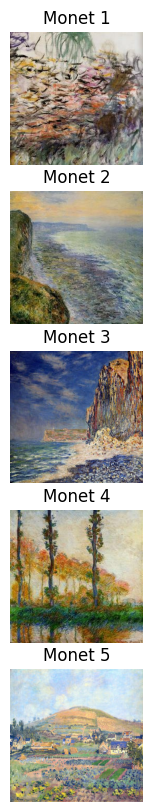

In [7]:
import matplotlib.pyplot as plt

def visualize_monet_paintings(dataset, num_samples=5):
    plt.figure(figsize=(10, num_samples * 2)) 
    for i, monet in enumerate(dataset.take(num_samples)):
        plt.subplot(num_samples, 1, i+1)  
        plt.title(f'Monet {i+1}')
        plt.imshow(monet[0] * 0.5 + 0.5)  
        plt.axis('off')
    plt.show()

visualize_monet_paintings(monet_ds)

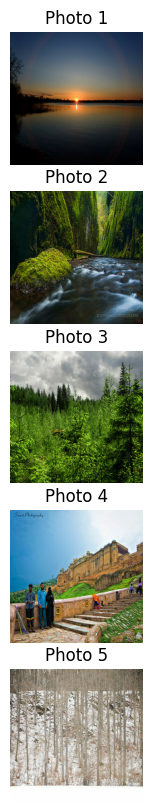

In [8]:
import matplotlib.pyplot as plt

def visualize_photos(dataset, num_samples=5):
    plt.figure(figsize=(10, num_samples * 2))  
    for i, photo in enumerate(dataset.take(num_samples)):
        plt.subplot(num_samples, 1, i+1)  
        plt.title(f'Photo {i+1}')
        plt.imshow(photo[0] * 0.5 + 0.5)  
        plt.axis('off')
    plt.show()

visualize_photos(photo_ds)

Pretty fun to look at! Next, we will compare the hue distribution between Monet paintings and normal photos to see the variation between the two.

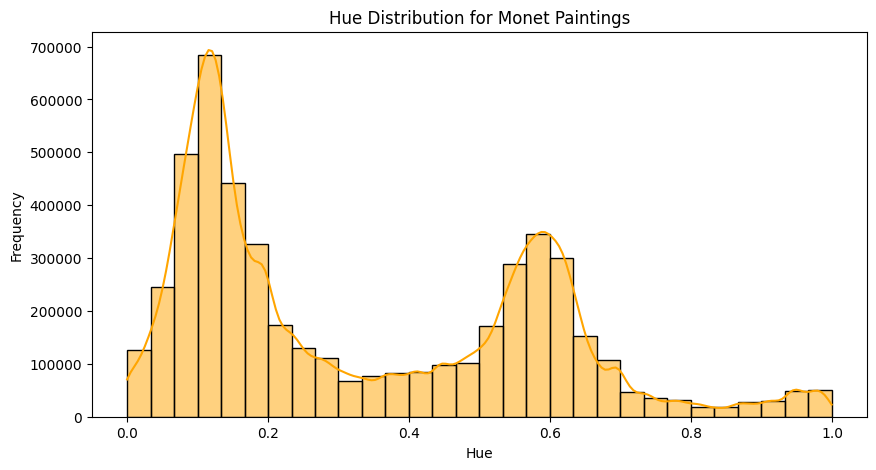

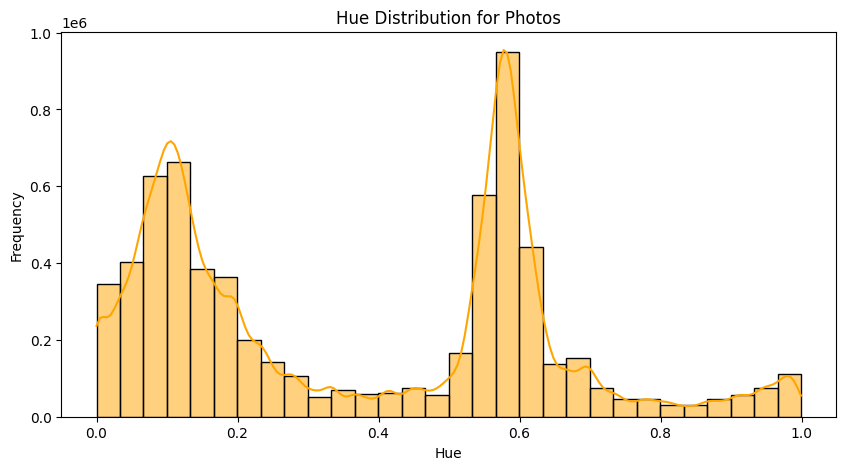

In [9]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import seaborn as sns

def plot_color_distribution(dataset, title):
    hues = []
    for image in dataset.take(100): 
        image = image[0]  
        hsv_image = tf.image.rgb_to_hsv(image)
        hue = hsv_image[..., 0]
        hue = tf.reshape(hue, [-1])
        hues.extend(hue.numpy())

    plt.figure(figsize=(10, 5))
    sns.histplot(hues, kde=True, bins=30, color='orange')
    plt.title(f'Hue Distribution for {title}')
    plt.xlabel('Hue')
    plt.ylabel('Frequency')
    plt.show()

plot_color_distribution(monet_ds, 'Monet Paintings')

plot_color_distribution(photo_ds, 'Photos')

The histograms above show the distribution in hue with both Monet paintings and photos. We can see a prominant spike around 0.6 for photos and a bit of a spike in the same area for Monet paintings. The same can be observed around 0.1 for both, with Monet paintings having a higher frequency around that area.

In [10]:
import tensorflow as tf
from tensorflow.keras import layers, Model

def Generator():
    inputs = layers.Input(shape=[256, 256, 3])

    down_stack = [
        layers.Conv2D(32, 4, strides=2, padding='same', activation='relu'),  
        layers.Conv2D(64, 4, strides=2, padding='same', activation='relu'),  
        layers.Conv2D(128, 4, strides=2, padding='same', activation='relu'),  
    ]

    up_stack = [
        layers.Conv2DTranspose(128, 4, strides=2, padding='same', activation='relu'),  
        layers.Conv2DTranspose(64, 4, strides=2, padding='same', activation='relu'),  
        layers.Conv2DTranspose(32, 4, strides=2, padding='same', activation='relu'),  
    ]

    x = inputs
    for layer in down_stack:
        x = layer(x)

    for layer in up_stack:
        x = layer(x)

    last = layers.Conv2D(3, 4, strides=1, padding='same', activation='tanh')
    x = last(x)

    return Model(inputs=inputs, outputs=x, name="Generator")

def Discriminator():
    inputs = layers.Input(shape=[256, 256, 3])

    x = layers.Conv2D(32, 4, strides=2, padding='same', activation='relu')(inputs) 
    x = layers.Conv2D(64, 4, strides=2, padding='same', activation='relu')(x)  
    x = layers.Conv2D(128, 4, strides=2, padding='same', activation='relu')(x)  

    last = layers.Conv2D(1, 4, strides=1, padding='same')
    x = last(x)

    return Model(inputs=inputs, outputs=x, name="Discriminator")

generator = Generator()
discriminator = Discriminator()

generator.summary()
discriminator.summary()

Model: "Generator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 128, 128, 32)   │         1,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 64)     │        32,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 128)    │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 64, 64, 128)    │       262,272 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 128, 128, 64)   │       131,136 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 256, 256, 32)   │        32,800 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 256, 256, 3)    │         1,539 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 593,347 (2.26 MB)

 Trainable params: 593,347 (2.26 MB)

 Non-trainable params: 0 (0.00 B)

Model: "Discriminator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 128, 128, 32)   │         1,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 64, 64, 64)     │        32,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 32, 32, 128)    │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 32, 32, 1)      │         2,049 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 167,649 (654.88 KB)

 Trainable params: 167,649 (654.88 KB)

 Non-trainable params: 0 (0.00 B)

Above is the results from the Generator and Discriminator models, showing how the images will be generated in the style of Monet's paintings. The generator model is the input layer that also contains convolutional layers. This is all used to downsample and then upsample the input to generate a new image. The discriminator model also has convolutional layers that downsample the input. This is used to classify images as real or generated with the tables showing the layer types, output shape, and the number of trainable parameters. The notebook in Kaggle for me was struggling to do more layers and I had to downsize it. I think this led to me having issues with having better results. I also had to lower the batch size quite a bit which I believe also played a part. If I could've done it in my own environment I believe the results would've been better, but this assignment for some reason doesn't allow for file uploads. 

In [11]:
generator_g = Generator()  
generator_f = Generator()  
discriminator_x = Discriminator()  
discriminator_y = Discriminator()  

In [12]:
from tensorflow.keras.mixed_precision import set_global_policy

set_global_policy('mixed_float16')

The following code is for the CycleGAN model, which is I would say the most important part of this project. We have a class definition, compile method, train step method, loss functions,optimzers, and so on. Ultimately, it sets up the training process for the CycleGAN model which is what transforms the images from regular photos to Monet-style photos while still keeping the underlying content in tact from the original photo. The model learns to translate content from the original source to the target domain, which is the Monet-style of the photo. The cycle-consistency loss ensures that an image can be translated from the original to the Monet-style, and then back to the original, helping the model preserve important parts of the input images.

In [13]:
import tensorflow as tf
from tensorflow.keras import Model, losses, optimizers

class CycleGan(tf.keras.Model):
    def __init__(self,
                 monet_generator,
                 photo_generator,
                 monet_discriminator,
                 photo_discriminator,
                 lambda_cycle=10):
        super(CycleGan, self).__init__()
        self.m_gen = monet_generator
        self.p_gen = photo_generator
        self.m_disc = monet_discriminator
        self.p_disc = photo_discriminator
        self.lambda_cycle = lambda_cycle

    def compile(self,
                m_gen_optimizer,
                p_gen_optimizer,
                m_disc_optimizer,
                p_disc_optimizer,
                gen_loss_fn,
                disc_loss_fn,
                cycle_loss_fn,
                identity_loss_fn):
        super(CycleGan, self).compile()
        self.m_gen_optimizer = m_gen_optimizer
        self.p_gen_optimizer = p_gen_optimizer
        self.m_disc_optimizer = m_disc_optimizer
        self.p_disc_optimizer = p_disc_optimizer
        self.gen_loss_fn = gen_loss_fn
        self.disc_loss_fn = disc_loss_fn
        self.cycle_loss_fn = cycle_loss_fn
        self.identity_loss_fn = identity_loss_fn

    def train_step(self, batch_data):
        real_monet, real_photo = batch_data
        
        with tf.GradientTape(persistent=True) as tape:
            fake_monet = self.m_gen(real_photo, training=True)
            cycled_photo = self.p_gen(fake_monet, training=True)

            fake_photo = self.p_gen(real_monet, training=True)
            cycled_monet = self.m_gen(fake_photo, training=True)

            same_monet = self.m_gen(real_monet, training=True)
            same_photo = self.p_gen(real_photo, training=True)

            disc_real_monet = self.m_disc(real_monet, training=True)
            disc_fake_monet = self.m_disc(fake_monet, training=True)
            disc_real_photo = self.p_disc(real_photo, training=True)
            disc_fake_photo = self.p_disc(fake_photo, training=True)

            gen_monet_loss = self.gen_loss_fn(disc_fake_monet)
            gen_photo_loss = self.gen_loss_fn(disc_fake_photo)

            total_cycle_loss = self.cycle_loss_fn(real_monet, cycled_monet, self.lambda_cycle) + \
                               self.cycle_loss_fn(real_photo, cycled_photo, self.lambda_cycle)

            total_monet_gen_loss = gen_monet_loss + total_cycle_loss + \
                                   self.identity_loss_fn(real_monet, same_monet, self.lambda_cycle)
            total_photo_gen_loss = gen_photo_loss + total_cycle_loss + \
                                   self.identity_loss_fn(real_photo, same_photo, self.lambda_cycle)

            monet_disc_loss = self.disc_loss_fn(disc_real_monet, disc_fake_monet)
            photo_disc_loss = self.disc_loss_fn(disc_real_photo, disc_fake_photo)

        monet_generator_gradients = tape.gradient(total_monet_gen_loss,
                                                  self.m_gen.trainable_variables)
        photo_generator_gradients = tape.gradient(total_photo_gen_loss,
                                                  self.p_gen.trainable_variables)

        monet_discriminator_gradients = tape.gradient(monet_disc_loss,
                                                      self.m_disc.trainable_variables)
        photo_discriminator_gradients = tape.gradient(photo_disc_loss,
                                                      self.p_disc.trainable_variables)

        self.m_gen_optimizer.apply_gradients(zip(monet_generator_gradients,
                                                 self.m_gen.trainable_variables))
        self.p_gen_optimizer.apply_gradients(zip(photo_generator_gradients,
                                                 self.p_gen.trainable_variables))
        self.m_disc_optimizer.apply_gradients(zip(monet_discriminator_gradients,
                                                  self.m_disc.trainable_variables))
        self.p_disc_optimizer.apply_gradients(zip(photo_discriminator_gradients,
                                                  self.p_disc.trainable_variables))

        return {
            'monet_gen_loss': total_monet_gen_loss,
            'photo_gen_loss': total_photo_gen_loss,
            'monet_disc_loss': monet_disc_loss,
            'photo_disc_loss': photo_disc_loss
        }


generator_g = Generator()  
generator_f = Generator()  
discriminator_x = Discriminator()  
discriminator_y = Discriminator()  

loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)
cycle_loss_fn = tf.keras.losses.MeanAbsoluteError()
identity_loss_fn = tf.keras.losses.MeanAbsoluteError()

def discriminator_loss(real, generated):
    real_loss = loss_object(tf.ones_like(real), real)
    generated_loss = loss_object(tf.zeros_like(generated), generated)
    total_disc_loss = real_loss + generated_loss
    return total_disc_loss * 0.5

def generator_loss(generated):
    return loss_object(tf.ones_like(generated), generated)

def calc_cycle_loss(real_image, cycled_image, LAMBDA=10):
    return LAMBDA * cycle_loss_fn(real_image, cycled_image)

def calc_identity_loss(real_image, same_image, LAMBDA=10):
    return LAMBDA * 0.5 * identity_loss_fn(real_image, same_image)

generator_g_optimizer = optimizers.Adam(2e-4, beta_1=0.5)
generator_f_optimizer = optimizers.Adam(2e-4, beta_1=0.5)
discriminator_x_optimizer = optimizers.Adam(2e-4, beta_1=0.5)
discriminator_y_optimizer = optimizers.Adam(2e-4, beta_1=0.5)

cycle_gan_model = CycleGan(generator_g, generator_f, discriminator_x, discriminator_y)
cycle_gan_model.compile(
    m_gen_optimizer=generator_g_optimizer,
    p_gen_optimizer=generator_f_optimizer,
    m_disc_optimizer=discriminator_x_optimizer,
    p_disc_optimizer=discriminator_y_optimizer,
    gen_loss_fn=generator_loss,
    disc_loss_fn=discriminator_loss,
    cycle_loss_fn=calc_cycle_loss,
    identity_loss_fn=calc_identity_loss
)

epochs = 25

train_dataset = tf.data.Dataset.zip((monet_ds, photo_ds))
train_dataset = train_dataset.shuffle(buffer_size=1000).prefetch(AUTOTUNE)

for epoch in range(epochs):
    for batch_data in train_dataset:
        cycle_gan_model.train_step(batch_data)

Below we can actually see the results of all of the work where there are five original photos not in Monet-style that are then shown in Monet-style. Again, I had to really lower the batch size and number of layers for the model to use which really effected the accuracy, but I'm just happy to have a finished product that somewhat resembles the end goal. I had to play around with not only getting all of this to work, but getting the project to actually submit since it's trickier only being able to submit a notebook rather than the previous two assignments where we got to submit the output file.

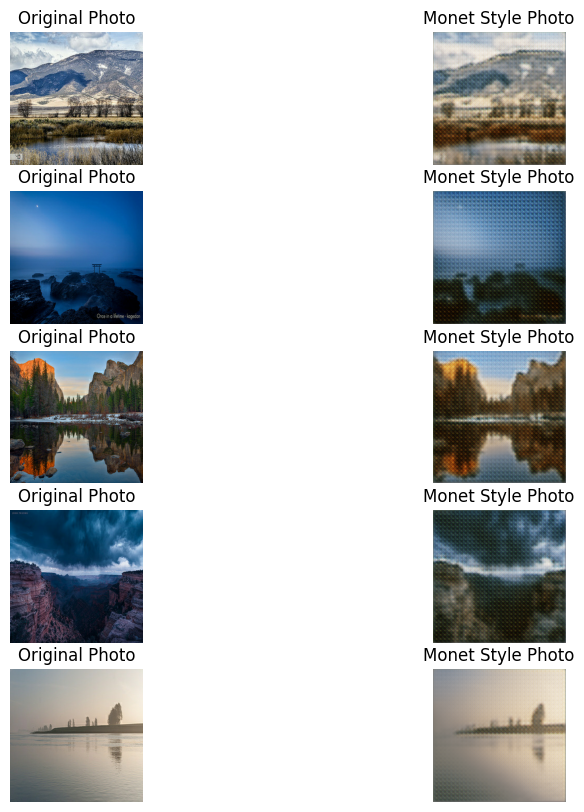

In [14]:
import tensorflow as tf
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

AUTOTUNE = tf.data.experimental.AUTOTUNE
IMAGE_SIZE = [256, 256]

def parse_tfrecord(example):
    feature_description = {
        'image_name': tf.io.FixedLenFeature([], tf.string),
        'image': tf.io.FixedLenFeature([], tf.string),
    }
    example = tf.io.parse_single_example(example, feature_description)
    image = tf.image.decode_jpeg(example['image'], channels=3)
    image = tf.reshape(image, [*IMAGE_SIZE, 3])
    image = (tf.cast(image, tf.float32) / 127.5) - 1
    return image

def load_photo_test_dataset(file_pattern):
    filenames = tf.io.gfile.glob(file_pattern)
    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.map(parse_tfrecord, num_parallel_calls=AUTOTUNE)
    return dataset

photo_test_ds = load_photo_test_dataset(photo_tfrec_path)

plt.figure(figsize=(10, 10))  

for i, photo in enumerate(photo_test_ds.take(5)):
    fake_monet = cycle_gan_model.m_gen(photo[None, ...], training=False)
    fake_monet = (fake_monet[0].numpy() * 0.5 + 0.5) * 255
    photo = (photo.numpy() * 0.5 + 0.5) * 255

    photo_image = Image.fromarray(photo.astype(np.uint8))
    fake_monet_image = Image.fromarray(fake_monet.astype(np.uint8))

    plt.subplot(5, 2, i*2 + 1)
    plt.title('Original Photo')
    plt.imshow(photo_image)
    plt.axis('off')

    plt.subplot(5, 2, i*2 + 2)
    plt.title('Monet Style Photo')
    plt.imshow(fake_monet_image)
    plt.axis('off')

plt.show()

This is where the output happens that goes through the images, and turns them into a zip file containing the images for the competition.

In [15]:
import os
from PIL import Image
import numpy as np
import shutil

output_dir = '/kaggle/working/images/'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

num_images = 8750

for i, photo in enumerate(photo_test_ds.take(num_images)):  
    fake_monet = cycle_gan_model.m_gen(photo[None, ...], training=False)
    fake_monet = (fake_monet[0].numpy() * 0.5 + 0.5) * 255
    fake_monet_image = Image.fromarray(fake_monet.astype(np.uint8))
    
    image_filename = f'{i:04d}.jpg'
    fake_monet_image.save(os.path.join(output_dir, image_filename))

shutil.make_archive('/kaggle/working/images', 'zip', output_dir)

import logging
logging.getLogger().setLevel(logging.ERROR)

In conclusion, I'm not happy with the results and definitely could've gotten better results locally in my own environment in VS Code, but I'm just happy like I said to have a finished product that somewhat resembles the end goal of a Monet-style photo, and also getting to the point of being able to successfully submit the notebook for a score since that was a bit tricky.